In [2]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
import time
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units
import models
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers

from recipes import fssh, fssh2, fssh3, gfsh

import libra_py.models.GLVC as GLVC


warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]


In [3]:
s = units.inv_cm2Ha
freqs = np.array([129.743484,263.643268,406.405874,564.000564,744.784527,
                  961.545250,1235.657107,1606.622430,2157.558683,3100.000000])*s
freqs = freqs.tolist()
g_vals = [0.000563,0.001143,0.001762,0.002446,0.003230,0.004170,0.005358,0.006966,0.009356,0.013444]
eps = 0.02
v0 = 0.001
m = 1836.0 # 1 amu
temperature = 300.0 # K
model_params = {"model": 0, "model0": 0,"nstates": 2, "num_osc": 10, "coupling_scaling": [1.0, -1.0], 
                "omega": [freqs]*2, "coupl": [g_vals]*2, "mass": [m]*10, "Ham": [[eps,-v0],[-v0,-eps]],
                "beta": 1/(units.kB*temperature)}

In [4]:
print(model_params["mass"])

[1836.0, 1836.0, 1836.0, 1836.0, 1836.0, 1836.0, 1836.0, 1836.0, 1836.0, 1836.0]


# Initial conditions

In [35]:
q_init = []
p_init = []
for i in range(len(freqs)):
    r_i = g_vals[i]/(model_params["mass"][i]*freqs[i]*freqs[i])
    p_i = np.sqrt(model_params["mass"][i]*freqs[i])
    q_init.append(r_i)
    p_init.append(p_i)
    print(f'for frequency {i}, the initial conditions are R={r_i}, P={p_i}')

for frequency 0, the initial conditions are R=0.8774472431019315, P=1.0418135808137907
for frequency 1, the initial conditions are R=0.43141633832361487, P=1.4850995952143318
for frequency 2, the initial conditions are R=0.2798785929498819, P=1.8438569506221296
for frequency 3, the initial conditions are R=0.20173493224604014, P=2.172135961176957
for frequency 4, the initial conditions are R=0.15276538604742568, P=2.496103328064242
for frequency 5, the initial conditions are R=0.11832604046327609, P=2.836168962066525
for frequency 6, the initial conditions are R=0.0920641392519203, P=3.215112857821115
for frequency 7, the initial conditions are R=0.07080102564855995, P=3.666098670157821
for frequency 8, the initial conditions are R=0.05272889983950311, P=4.248430763572734
for frequency 9, the initial conditions are R=0.03670192528380918, P=5.092465359448556


## 4. Choose the Nonadiabatic Methodology
<a name="4"></a>[Back to TOC](#TOC)

In [38]:
############################################################
##### 2. Choose the Nonadiabatic Dynamics Methodology 
############################################################
NSTATES = 2
dyn_general = { "nsteps":100000, "ntraj":100, "nstates":NSTATES,
                "dt": 1.0, "num_electronic_substeps":1, "isNBRA":0, "is_nbra":0,
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),      
                "mem_output_level":3,
                "properties_to_save":[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
                "states", "se_pop_adi", "se_pop_dia", "sh_pop_adi", "sh_pop_dia"],
                "prefix":"adiabatic_md", "prefix2":"adiabatic_md"
              }
fssh.load(dyn_general) # FSSH

In [28]:
print(dyn_general["dt"])

1.0


In [29]:
############################################################
### 3. Choose the initial conditions: Nuclear and Electronic
############################################################
# Nuclear initial conditions 
beta = model_params["beta"]
_nosc = ndof = model_params["num_osc"]
_nst = NSTATES 

# 1/2 * mass * beta * w**2 = 1/2 * (1/sigma_q**2) => sigma_q = 1/(w * sqrt(mass * beta))
# 1/2 * (beta/mass) = 1/2 * (1/sigma_p**2) => sigma_p = 1/(sqrt(beta/mass))
# force_constant = mass * w**2
nucl_params = { "ndof":ndof,
                "q":[0.0 for i in range(ndof)],
                "p":[0.0 for i in range(ndof)],
                "mass":list(model_params["mass"]),
                "force_constant":[ model_params["mass"][i]*model_params["omega"][0][i]**2 for i in range(_nosc) ],
                "q_width":[ 1.0/( np.sqrt(model_params["mass"][i] * beta) * model_params["omega"][0][i]) for i in range(_nosc)  ],
                "p_width":[ 1.0/( np.sqrt(beta/model_params["mass"][i])) for i in range(_nosc)  ],
                "init_type": 4
              }
dt = 1.0 # atomic unit
print(F"dt = {dt}")

# Electronic initial conditions - start on the second diabatic state (starting from 0 = ground)
##########
istate = 1
##########
istates = [0.0 for i in range(NSTATES)]
istates[istate] = 1.0     
print(istates)
elec_params = {"verbosity":2, "init_dm_type":0,"ndia":NSTATES, "nadi":NSTATES, 
               "rep":1, "init_type":0, "istates":istates, "istate":istate     }

dt = 1.0
[0.0, 1.0]


## 6. Run the NA-MD calculations
<a name="6"></a>[Back to TOC](#TOC)

Finally, we are ready to run the calculations:
<a name="generic_recipe-1"></a>

In [30]:
def compute_model(q, params, full_id):
    model = params["model"]
    res = None

    if model==0:
        res = GLVC.GLVC(q, params, full_id)
    else:
        pass

    return res


def potential(q, params):
    full_id = Py2Cpp_int([0,0]) 
    
    return compute_model(q, params, full_id)

In [43]:

############################################################
### 4. Run the calculations and save the results into the HDF5 files
############################################################
x1 = time.time()
dyn_params = dict(dyn_general)
pref = F"FSSH_50_7"
dyn_params.update({ "prefix":pref, "prefix2":pref })
print(F"Computing {pref}")    

rnd = Random()
res = tsh_dynamics.generic_recipe(dyn_params, compute_model, model_params, elec_params, nucl_params, rnd)
print('ELAPSED TIME', time.time()-x1,' seconds')

Computing FSSH_50_7
Active states (adiabatic)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Initial adiabatic populations
[0.0, 1.0]
 step= 0
 step= 10000
 step= 20000
 step= 30000
 step= 40000
 step= 50000
 step= 60000
 step= 70000
 step= 80000
 step= 90000
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'q', 'p', 'f', 'Cadi', 'Cdia', 'Epot_ave', 'Ekin_ave', 'Etot_ave', 'states', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi', 'sh_pop_dia']
keywords =  ['timestep', 'time', 'q', 'p', 'f', 'Cadi', 'Cdia', 'Epot_ave', 'Ekin_ave', 'Etot_ave', 'states', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi', 'sh_pop_dia']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'states', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi', '

## 7. Plot the results
<a name="7"></a>[Back to TOC](#TOC)
<a name="plot_dynamics-1"></a>

0
1
2
3
4
5
6
7


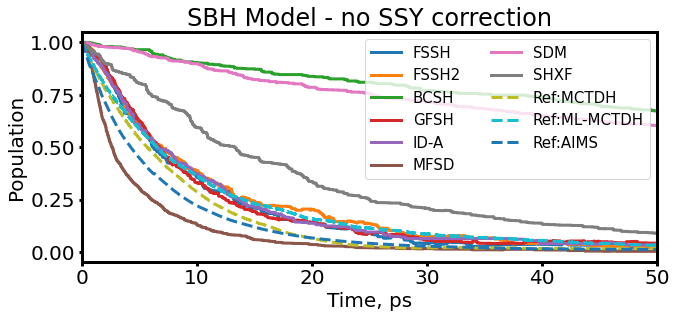

In [8]:
%matplotlib inline
labels = ['FSSH',
'FSSH2',
'BCSH',
'GFSH',
'ID-A',
'MFSD',
'SDM',
'SHXF'
]
folders = ['FSSH',
'FSSH2',
'BCSH',
'GFSH',
'ID-A',
'MFSD',
'SDM',
'SHXF'
]
plt.rcParams.update({'font.size': 20, 'axes.linewidth': 3, 'xtick.major.width': 3, 'ytick.major.width': 3})
plt.figure(figsize=(3.21*3, 2.41*2))
for k in range(len(folders)):
    print(k)
    sh_pops = []
    for i in range(0,51):
        file = f'{folders[k]}_ntraj_100_iter_{i}/mem_data.hdf'
        F = h5py.File(file)
        sh_pops.append(np.array(F['sh_pop_adi/data']))
        F.close()
    F = h5py.File(file)
    time_vec = F['time/data'][:]*units.au2fs/1000
    F.close()
    plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label=labels[k], lw=3.0)

mctdh = np.loadtxt('../reference/MCTDH_n16_N64.dat')
ml_mctdh = np.loadtxt('../reference/ML-MCTDH_n32.dat')
aims = np.loadtxt('../reference/CSS_AIMS_pop2.dat')
plt.plot(mctdh[:,0]/1000, mctdh[:,1], label='Ref:MCTDH', lw=3.0, ls='dashed')
plt.plot(ml_mctdh[:,0]/1000, ml_mctdh[:,1], label='Ref:ML-MCTDH', lw=3.0, ls='dashed')
plt.plot(aims[:,0], aims[:,1], label='Ref:AIMS', lw=3.0, ls='dashed')
plt.xlim(0,50)
plt.legend(fontsize=15, ncol=2, loc='upper right')
plt.ylabel('Population')
plt.xlabel('Time, ps')
plt.title('SBH Model - no SSY correction')
plt.tight_layout()
plt.savefig('../spin_boson_model_assessment.jpg', dpi=600)

In [4]:
%matplotlib inline
labels = ['FSSH',
'FSSH2',
'BCSH',
'GFSH',
'ID-A',
'MFSD',
'SDM',
'SHXF'
]
folders = ['FSSH',
'FSSH2',
'BCSH',
'GFSH',
'ID-A',
'MFSD',
'SDM',
'SHXF'
]
plt.rcParams.update({'font.size': 20, 'axes.linewidth': 3})
plt.figure(figsize=(3.21*3, 2.41*2))
for k in range(len(folders)):
    print(k)
    sh_pops = []
    for i in range(0,51):
        file = f'{folders[k]}_ntraj_100_iter_{i}_SSY/mem_data.hdf'
        F = h5py.File(file)
        sh_pops.append(np.array(F['sh_pop_adi/data']))
        F.close()
    F = h5py.File(file)
    time_vec = F['time/data'][:]*units.au2fs/1000
    F.close()
    plt.plot(time_vec[0::1], np.average(sh_pops, axis=0)[0::1,1], label=labels[k], lw=3.0)

mctdh = np.loadtxt('../reference/MCTDH_n16_N64.dat')
ml_mctdh = np.loadtxt('../reference/ML-MCTDH_n32.dat')
aims = np.loadtxt('../reference/CSS_AIMS_pop2.dat')
plt.plot(mctdh[:,0]/1000, mctdh[:,1], label='Ref:MCTDH', lw=3.0, ls='dashed')
plt.plot(ml_mctdh[:,0]/1000, ml_mctdh[:,1], label='Ref:ML-MCTDH', lw=3.0, ls='dashed')
plt.plot(aims[:,0], aims[:,1], label='Ref:AIMS', lw=3.0, ls='dashed')
plt.xlim(0,50)
plt.legend(fontsize=15, ncol=2)
plt.ylabel('Population')
plt.xlabel('Time, ps')
plt.title('SBH Model - with SSY correction')
plt.tight_layout()
plt.savefig('../spin_boson_model_assessment_ssy.jpg', dpi=600)

0


KeyboardInterrupt: 

<Figure size 693.36x347.04 with 0 Axes>

# Error measurement

In [5]:
sh_pops[0][0:2100000:5,1].shape

(420000,)

In [5]:
nsteps = 500000
all_errors = []
for k in range(len(folders)):
    print(k)
    errors = []
    sh_pops = []
    for i in range(0,51):
        file = f'{folders[k]}_ntraj_100_iter_{i}/mem_data.hdf'
        F = h5py.File(file)
        sh_pop = np.array(F['sh_pop_adi/data'])
        F.close()
        #print(sh_pop.shape)
        error1 = np.average(np.abs(mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
        error2 = np.average(np.abs(ml_mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
        errors.append([error1, error2])
    all_errors.append(errors)
    F = h5py.File(file)
    time_vec = F['time/data'][:]*units.au2fs/1000
    F.close()

# print(mctdh.shape, ml_mctdh.shape)
all_errors = np.array(all_errors)
print(all_errors.shape)
# print(all_errors)

0


NameError: name 'mctdh' is not defined

In [26]:
print(plt.rcParams)

_internal.classic_mode: False
agg.path.chunksize: 0
animation.bitrate: -1
animation.codec: h264
animation.convert_args: []
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: black
axes.facecolor: white
axes.formatter.limits: [-5, 6]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: black
axes.labelpad: 4.0
axes.labelsize: medium
axes.labelweight: normal
axes.linewidth: 3.0
axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
axes.spines.bottom: True
axes.spines.left: True
axes.spines.right: True
axes.spines.

In [3]:
%matplotlib inline
for i in range(len(labels)):
    mctdh_ave_error = np.average(all_errors[i,:,0])
    mctdh_error_bar = 1.96*np.std(all_errors[i,:,0])/np.sqrt(51)
#     print(f'{labels[i]}: {mctdh_ave_error} $\\pm$ {mctdh_error_bar}')
plt.rcParams.update({'font.size': 20, 'axes.linewidth': 3, 'lines.linewidth': 3.0, 'xtick.major.width': 2.0})
plt.figure(figsize=(3.21*3,2.41*2))
bar_colors = ['red','blue','darkgreen','cyan', 'gray','yellow','darkblue','green']#,'green','darkgreen']
errors = np.sort(np.average(all_errors[:,:,0], axis=1))
error_bars = 1.96*np.std(all_errors[:,:,0], axis=1)/np.sqrt(51)
new_indices = np.argsort(np.average(all_errors[:,:,0], axis=1))
# print()
plt.bar(np.array(labels)[new_indices], errors, color=bar_colors)
plt.errorbar([0,1,2,3,4,5,6,7], errors, 
             error_bars[new_indices], capsize=15,
            capthick=2.0, marker='s', markersize=10, ls='', color='black')
# plt.scatter([1,2,3,4,5,6,7,8], np.average(all_errors[:,:,0], axis=1), marker='s', size=4)
# plt.ylim(0,1)
# plt.xticks([0,1,2,3,4,5,6,7],labels)
# plt.yscale('log')
plt.ylabel('$\\epsilon_{pop}$')
plt.title('Population error: MCTDH reference')
plt.tight_layout()
plt.savefig('../pop_error_mctdh.jpg', dpi=600)
print('----------------------------------')
for i in range(len(labels)):
    ml_mctdh_ave_error = np.average(all_errors[i,:,1])
    ml_mctdh_error_bar = 1.96*np.std(all_errors[i,:,1])/np.sqrt(51)
#     print(f'{labels[i]}: {ml_mctdh_ave_error} $\\pm$ {ml_mctdh_error_bar}')
plt.rcParams.update({'font.size': 20, 'axes.linewidth': 3, 'lines.linewidth': 3.0})
plt.figure(figsize=(3.21*3,2.41*2))
bar_colors = ['cyan','blue','darkgreen','red', 'yellow','gray','darkblue','green']#,'green','darkgreen']
errors = np.sort(np.average(all_errors[:,:,1], axis=1))
error_bars = 1.96*np.std(all_errors[:,:,1], axis=1)/np.sqrt(51)
new_indices = np.argsort(np.average(all_errors[:,:,1], axis=1))
# print()
plt.bar(np.array(labels)[new_indices], errors, color=bar_colors)
plt.errorbar([0,1,2,3,4,5,6,7], errors, 
             error_bars[new_indices], capsize=15,
            capthick=2.0, marker='s', markersize=10, ls='', color='black')
# plt.scatter([1,2,3,4,5,6,7,8], np.average(all_errors[:,:,0], axis=1), marker='s', size=4)
# plt.ylim(0,1)
# plt.xticks([0,1,2,3,4,5,6,7],labels)
# plt.yscale('log')
plt.ylabel('$\\epsilon_{pop}$')
plt.title('Population error: ML-MCTDH reference')
plt.tight_layout()
plt.savefig('../pop_error_ml_mctdh.jpg', dpi=600)

NameError: name 'labels' is not defined

# with SSY

In [85]:
nsteps = 500000
all_errors = []
for k in range(len(folders)):
    print(k)
    errors = []
    sh_pops = []
    for i in range(0,51):
        file = f'{folders[k]}_ntraj_100_iter_{i}_SSY/mem_data.hdf'
        F = h5py.File(file)
        sh_pop = np.array(F['sh_pop_adi/data'])
        F.close()
        #print(sh_pop.shape)
        error1 = np.average(np.abs(mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
        error2 = np.average(np.abs(ml_mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
        errors.append([error1, error2])
    all_errors.append(errors)
    F = h5py.File(file)
    time_vec = F['time/data'][:]*units.au2fs/1000
    F.close()

# print(mctdh.shape, ml_mctdh.shape)
all_errors = np.array(all_errors)
print(all_errors.shape)
# print(all_errors)

0
1
2
3
4
5
6
7
(8, 51, 2)


----------------------------------


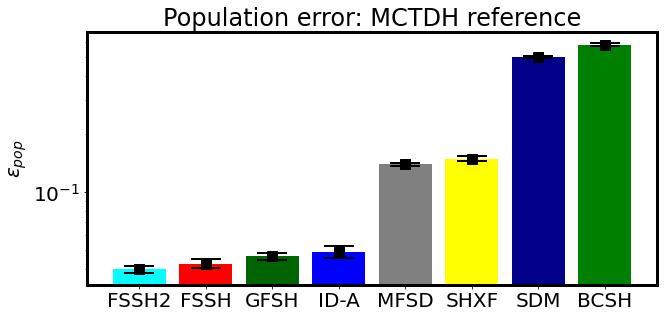

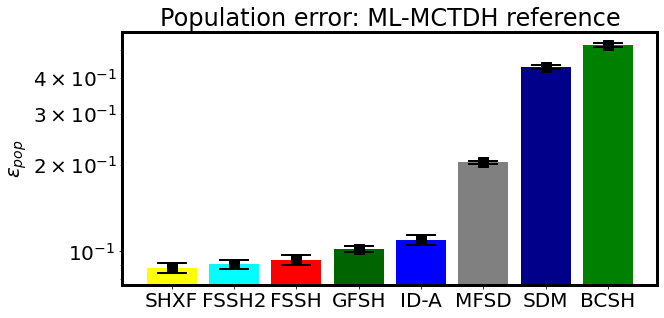

In [89]:
%matplotlib inline
for i in range(len(labels)):
    mctdh_ave_error = np.average(all_errors[i,:,0])
    mctdh_error_bar = 1.96*np.std(all_errors[i,:,0])/np.sqrt(51)
#     print(f'{labels[i]}: {mctdh_ave_error} $\\pm$ {mctdh_error_bar}')
plt.rcParams.update({'font.size': 20, 'axes.linewidth': 3, 'lines.linewidth': 3.0})
plt.figure(figsize=(3.21*3,2.41*2))
bar_colors = ['cyan','red','darkgreen','blue', 'gray','yellow','darkblue','green']#,'green','darkgreen']
errors = np.sort(np.average(all_errors[:,:,0], axis=1))
error_bars = 1.96*np.std(all_errors[:,:,0], axis=1)/np.sqrt(51)
new_indices = np.argsort(np.average(all_errors[:,:,0], axis=1))
# print()
plt.bar(np.array(labels)[new_indices], errors, color=bar_colors)
plt.errorbar([0,1,2,3,4,5,6,7], errors, 
             error_bars[new_indices], capsize=15,
            capthick=2.0, marker='s', markersize=10, ls='', color='black')
# plt.scatter([1,2,3,4,5,6,7,8], np.average(all_errors[:,:,0], axis=1), marker='s', size=4)
# plt.ylim(0,1)
# plt.xticks([0,1,2,3,4,5,6,7],labels)
plt.yscale('log')
plt.ylabel('$\\epsilon_{pop}$')
plt.title('Population error: MCTDH reference')
plt.tight_layout()
plt.savefig('../pop_error_mctdh_ssy_log.jpg', dpi=600)
print('----------------------------------')
for i in range(len(labels)):
    ml_mctdh_ave_error = np.average(all_errors[i,:,1])
    ml_mctdh_error_bar = 1.96*np.std(all_errors[i,:,1])/np.sqrt(51)
#     print(f'{labels[i]}: {ml_mctdh_ave_error} $\\pm$ {ml_mctdh_error_bar}')
plt.rcParams.update({'font.size': 20, 'axes.linewidth': 3, 'lines.linewidth': 3.0})
plt.figure(figsize=(3.21*3,2.41*2))
bar_colors = ['yellow','cyan','red','darkgreen', 'blue','gray','darkblue','green']#,'green','darkgreen']
errors = np.sort(np.average(all_errors[:,:,1], axis=1))
error_bars = 1.96*np.std(all_errors[:,:,1], axis=1)/np.sqrt(51)
new_indices = np.argsort(np.average(all_errors[:,:,1], axis=1))
# print()
plt.bar(np.array(labels)[new_indices], errors, color=bar_colors)
plt.errorbar([0,1,2,3,4,5,6,7], errors, 
             error_bars[new_indices], capsize=15,
            capthick=2.0, marker='s', markersize=10, ls='', color='black')
# plt.scatter([1,2,3,4,5,6,7,8], np.average(all_errors[:,:,0], axis=1), marker='s', size=4)
# plt.ylim(0,1)
# plt.xticks([0,1,2,3,4,5,6,7],labels)
plt.yscale('log')
plt.ylabel('$\\epsilon_{pop}$')
plt.title('Population error: ML-MCTDH reference')
plt.tight_layout()
plt.savefig('../pop_error_ml_mctdh_ssy_log.jpg', dpi=600)

'\nplot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":4,\n                "which_trajectories":[0], "which_dofs":[0], "which_adi_states":list(range(NSTATES)),\n                "which_dia_states":list(range(NSTATES)),\n                "frameon":True, "linewidth":3, "dpi":300,\n                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,\n                "what_to_plot":[ "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham" ],\n                "which_energies":["potential", "kinetic", "total"],\n                "save_figures":1, "do_show":0, "no_label":1\n              }\ntsh_dynamics_plot.plot_dynamics(plot_params)\n'

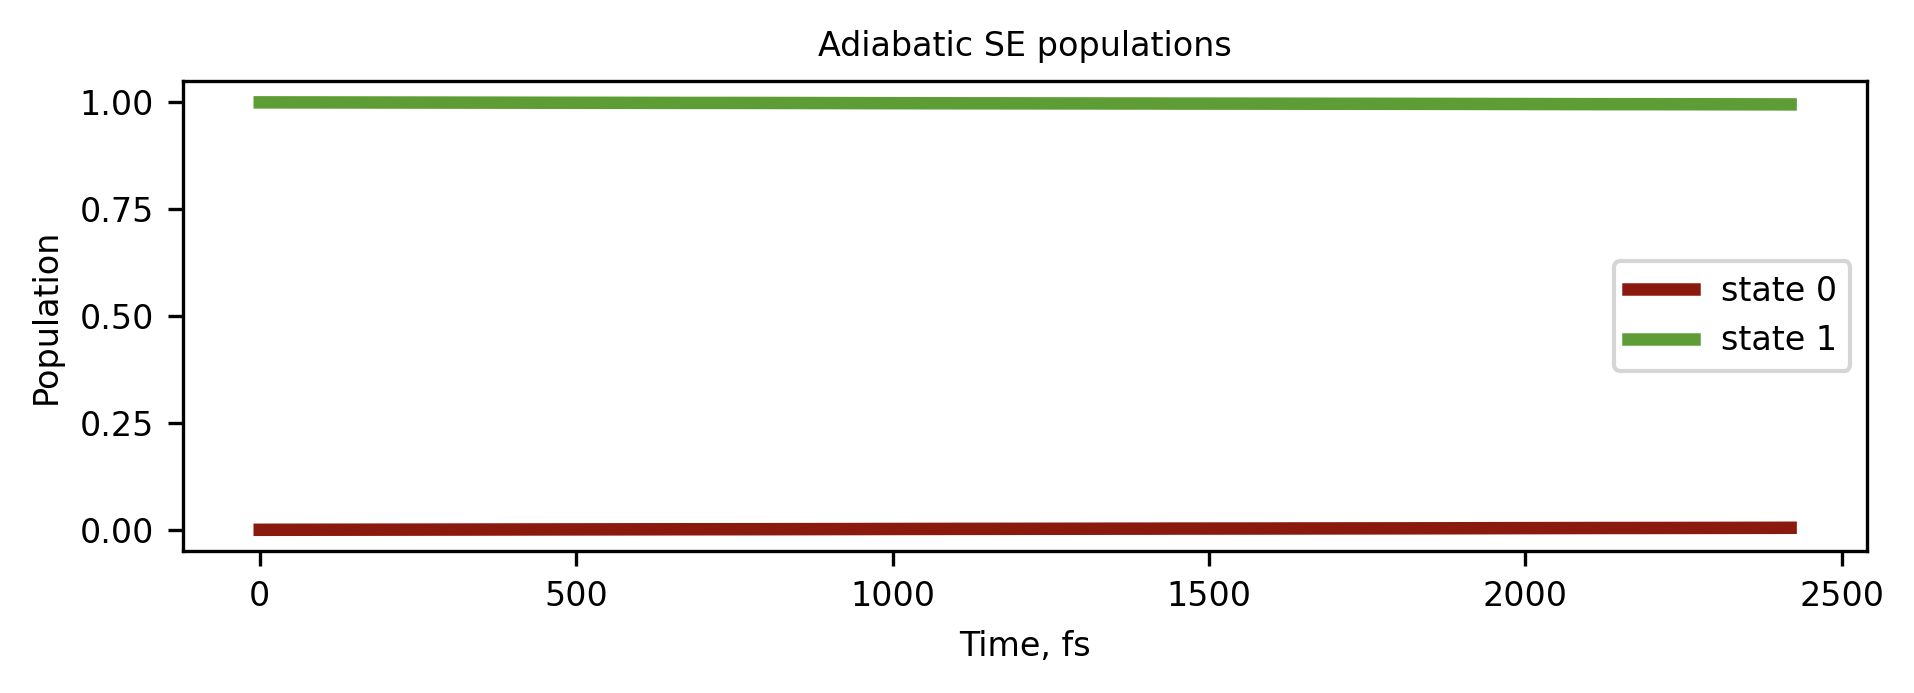

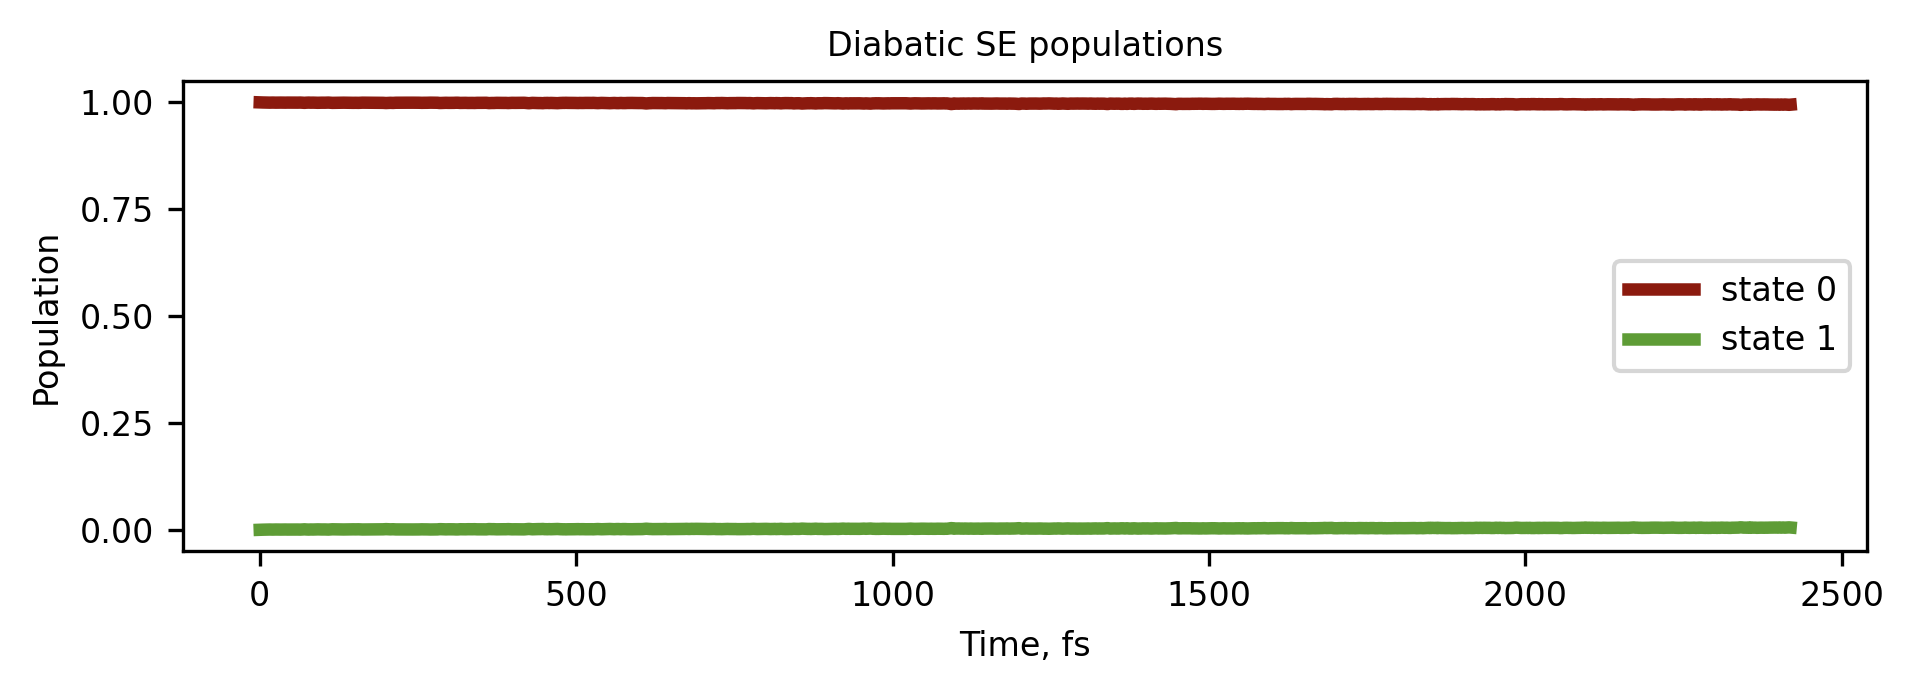

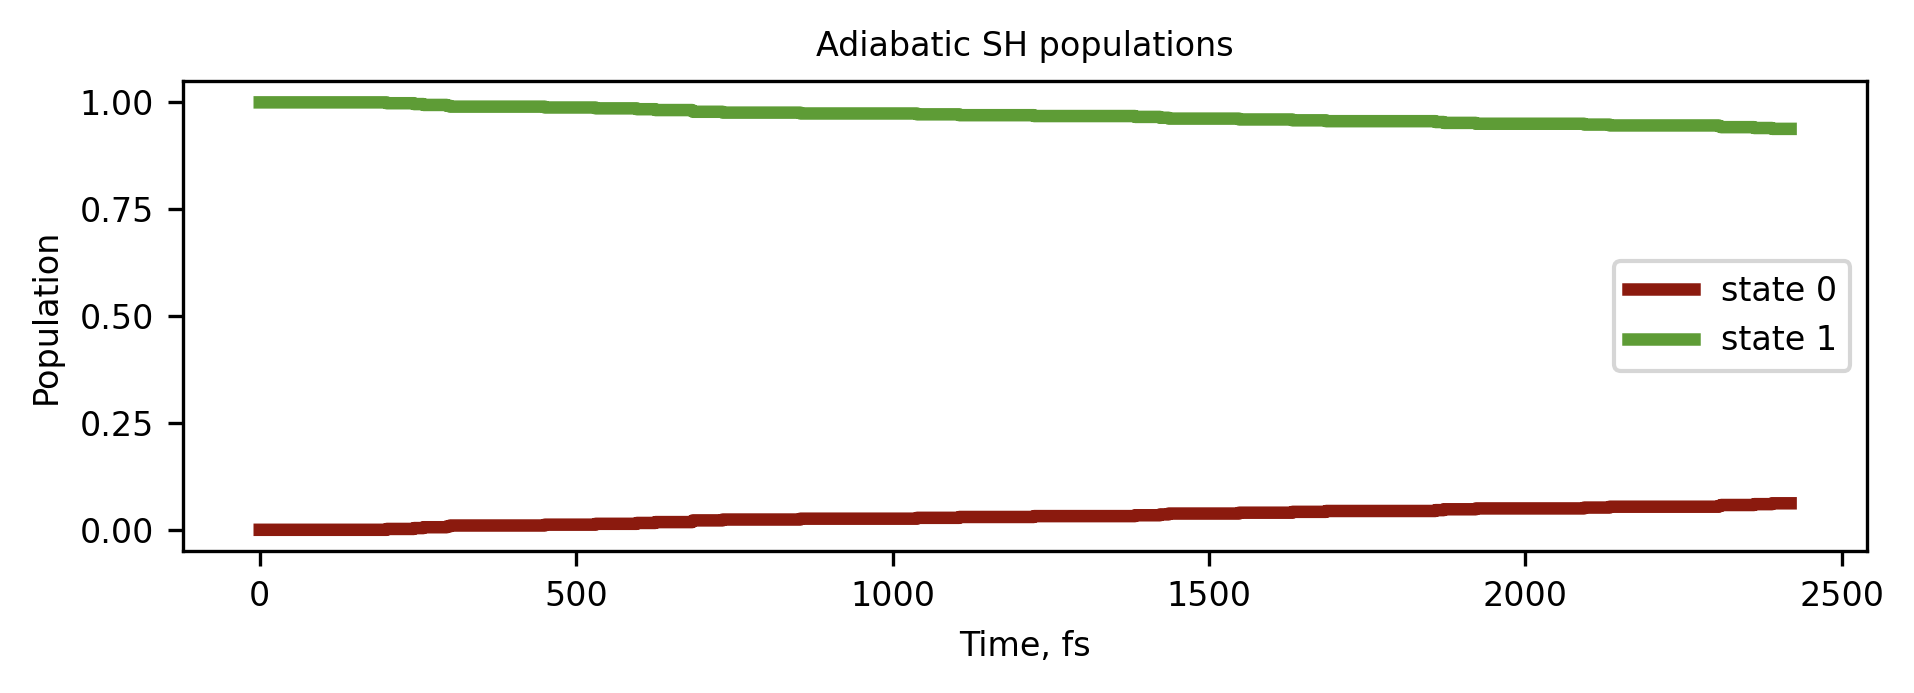

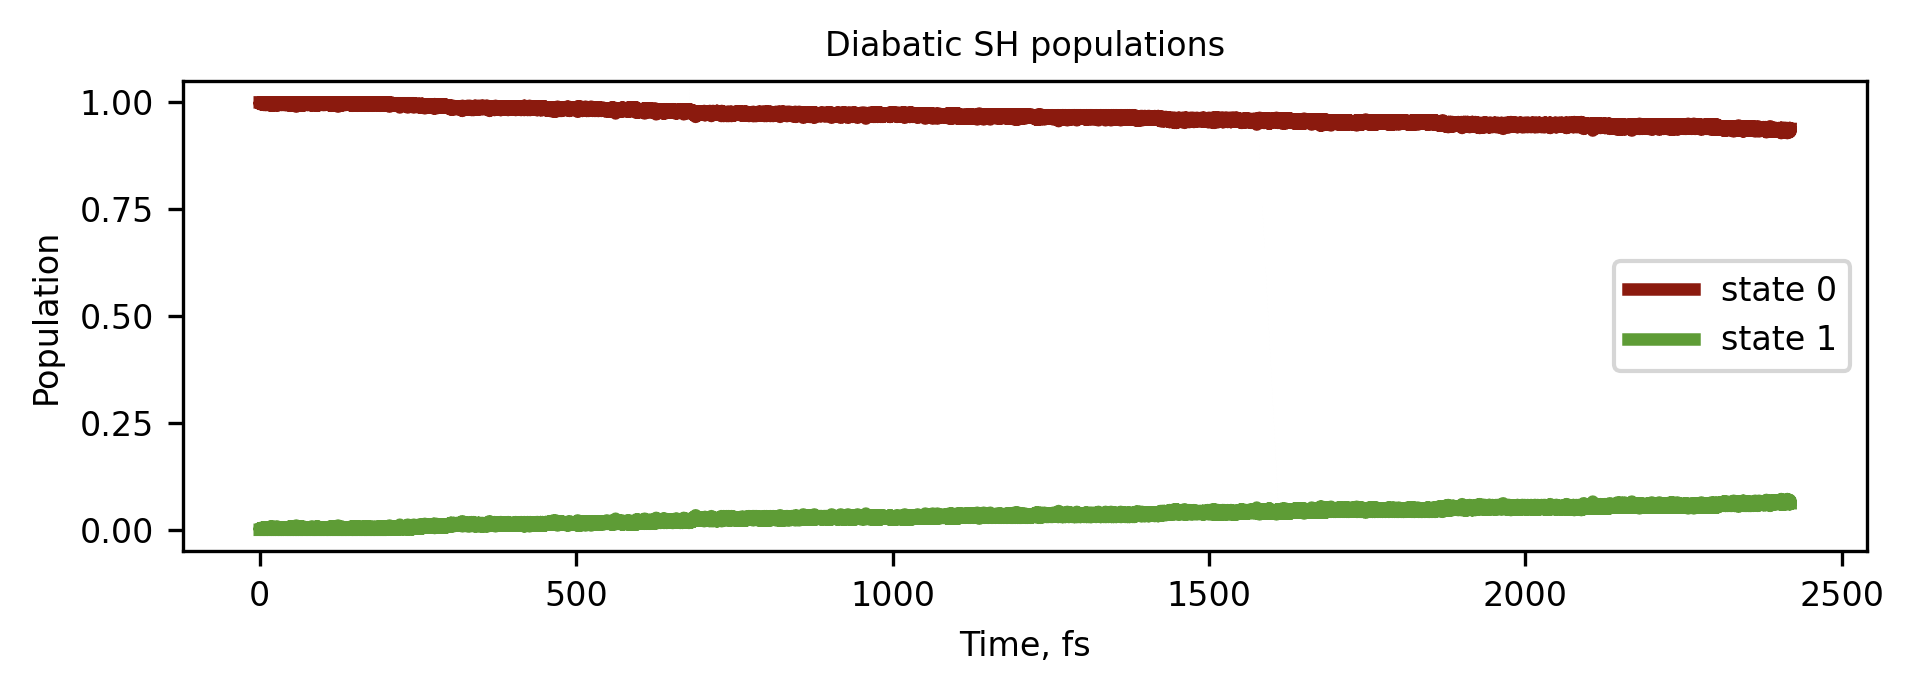

In [12]:
############################################################
### 5. Plot the results - preliminary plotting
############################################################

NTRAJ = dyn_general["ntraj"]
plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":list(range(NTRAJ)), "which_dofs":[9], "which_adi_states":list(range(NSTATES)), 
                "which_dia_states":list(range(NSTATES)), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                #"what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
                #                "se_pop_dia", "sh_pop_adi", "sh_pop_dia" ], 
                "what_to_plot":["se_pop_adi", "se_pop_dia", "sh_pop_adi", "sh_pop_dia" ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":0, "no_label":1
              }
tsh_dynamics_plot.plot_dynamics(plot_params)


# The block commented below will show the evolution of diabatiic and adiabatiic energy levels for the first trajectory.
# However, to plot it - you need to run the calculations using "mem_output_level":2, and defining "hvib_adi" and "hvib_dia"
# in the "properties_to_save"
"""
plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":4,
                "which_trajectories":[0], "which_dofs":[0], "which_adi_states":list(range(NSTATES)),
                "which_dia_states":list(range(NSTATES)),
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":[ "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham" ],
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":0, "no_label":1
              }
tsh_dynamics_plot.plot_dynamics(plot_params)
"""